| Coluna        | Descrição |
|--------------|-----------|
| **InvoiceNo** | Identificador único da fatura (nota fiscal). Valores que começam com **"C"** indicam **cancelamentos ou devoluções**. |
| **StockCode** | Código único do produto no sistema da empresa. |
| **Description** | Descrição textual do produto vendido. |
| **Quantity** | Quantidade de unidades do produto na transação.  |
| **InvoiceDate** | Data e hora em que a transação foi realizada. |
| **UnitPrice** | Preço unitário do produto.|
| **CustomerID** | Identificador único do cliente. Pode conter valores ausentes para clientes não cadastrados. |
| **Country** | País onde o cliente está localizado. |


In [692]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [693]:
df = pd.read_csv('../data/data.csv', encoding='latin1')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


Podemos notar através da função describe que temos valores **negativos** em Quantity (Quantidade) e UnitPrice (Preço unitário), isso quer dizer que em Quantity há cancelamentos e em UnitPrice há erros já que preço não pode ser negativo.

Além disso, nota-se que os valores máximos de Quantity e UnitPrice estão **muito acima do percentil 75%** , evidenciando uma distribuição **altamente assimétrica**. Enquanto 75% dos registros apresentam Quantity ≤ 10 e UnitPrice ≤ 4,13, existem observações com valores extremamente elevados, que se distanciam significativamente da média.

Apesar da média estar próxima do percentil 75%, indicando uma **grande concentração de valores baixos**, a presença desses valores extremos exerce forte influência nas estatísticas descritivas, caracterizando a **existência de outliers relevantes**.

Estes outliers **devem** ser tratados pois eles influenciam tanto na predição do modelo quanto na visualização gráfica (A escala fica muito grande, **cauda longa**)

In [694]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


Através deste describe conseguimos descobrir que o produto mais vendido foi o WHITE HANGING HEART T-LIGHT HOLDER,  dentre os 38 países United Kingdom (Reino unido) foi o país que mais foram feito vendas, o cliente de InvoiceNo 573585 foi o cliente que mais comprou de uma só vez levando 1114 itens.

In [695]:
df.sample(7, random_state=1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
94801,C544414,22960,JAM MAKING SET WITH JARS,-2,2/18/2011 14:54,3.75,13408.0,United Kingdom
210111,555276,48111,DOORMAT 3 SMILEY CATS,1,6/1/2011 17:28,15.79,NaN,United Kingdom
455946,575656,22952,60 CAKE CASES VINTAGE CHRISTMAS,48,11/10/2011 14:29,0.55,13319.0,United Kingdom
403542,571636,20674,GREEN POLKADOT BOWL,16,10/18/2011 11:41,1.25,13509.0,United Kingdom
471951,576657,22556,PLASTERS IN TIN CIRCUS PARADE,12,11/16/2011 11:03,1.65,12720.0,Germany
380570,569823,23298,SPOTTY BUNTING,1,10/6/2011 12:15,4.95,16895.0,United Kingdom
384867,570185,21090,WET/MOULDY,-192,10/7/2011 14:56,0.00,NaN,United Kingdom


Neste sample conseguimos identificar um registro (Primeiro da lista) que possui um C na frente do InvoiceNo, isso representa um **cancelamento**, iremos **separar os cancelamentos**, **colocar em outro dataframe para fazer análises posteriores** e iremos **excluir as compras canceladas deste dataset**.
Podemos perceber também que no último e no primeiro registro temos valores negativos em Quantity. No primeiro registro está correto ser negativo já que ocorreu um cancelamento indicado pelo C no InvoiceNo, já no último registro do sample o InvoiceNo não indica cancelamento mas Quantity está negativo, ou seja, este é um **registro com erro**, precisamos excluir, **iremos excluir todos os valores negativos em Quantity e Tudo que começa com C em InvoiceNo**.

### Verificando cancelamentos e guardando no dataframe df_cancelamentos :

In [696]:
df_cancelamentos = df[df['InvoiceNo'].str.startswith('C')]
df_cancelamentos.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


Podemos perceber agora que temos registros especiais em StockCode, como D em Discount, como iremos fazer segmentação e análise de retenção para clientes podemos excluir também estes registros especiais do dataset.

### Excluindo do dataframe os registros de cancelamento ou devolução :

In [697]:
df = df[~df['InvoiceNo'].str.startswith('C')]

### Verificando os registros especiais :

In [698]:
reg_especiais = df['StockCode'].str.match(r'^[A-Za-z]')

df[reg_especiais]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,12/1/2010 8:45,18.00,12583.0,France
386,536403,POST,POSTAGE,1,12/1/2010 11:27,15.00,12791.0,Netherlands
1123,536527,POST,POSTAGE,1,12/1/2010 13:04,18.00,12662.0,Germany
1423,536540,C2,CARRIAGE,1,12/1/2010 14:05,50.00,14911.0,EIRE
1814,536544,DOT,DOTCOM POSTAGE,1,12/1/2010 14:32,569.77,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541216,581494,POST,POSTAGE,2,12/9/2011 10:13,18.00,12518.0,Germany
541540,581498,DOT,DOTCOM POSTAGE,1,12/9/2011 10:26,1714.17,NaN,United Kingdom
541730,581570,POST,POSTAGE,1,12/9/2011 11:59,18.00,12662.0,Germany
541767,581574,POST,POSTAGE,2,12/9/2011 12:09,18.00,12526.0,Germany


### retirando - os do dataframe :

In [699]:
df = df[df['StockCode'].str.match(r'^\d')]

df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


### Verificando dados faltantes :

In [700]:
print(df.info())

print('\n Dados faltantes: \n\n',df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 530210 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    530210 non-null  object 
 1   StockCode    530210 non-null  object 
 2   Description  528771 non-null  object 
 3   Quantity     530210 non-null  int64  
 4   InvoiceDate  530210 non-null  object 
 5   UnitPrice    530210 non-null  float64
 6   CustomerID   396370 non-null  float64
 7   Country      530210 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.4+ MB
None

 Dados faltantes: 

 InvoiceNo           0
StockCode           0
Description      1439
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133840
Country             0
dtype: int64


Foi verificado que possuimos dados faltantes em Description (1439 registros) e em CustomerID (133840). Nestes casos não podemos imputar nada, CustomerID é um valor aleatório e Description é um produto.
Verificando os tipos de dados temos que nos atentar a colocar o InvoiceDate para formato de data (datetime), irei fazer isso no código abaixo.

In [701]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

### Verificando os dados faltantes :

In [702]:
df_missing = df[df['CustomerID'].isnull() | df['Description'].isnull()]
df_missing


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541535,581498,85049e,SCANDINAVIAN REDS RIBBONS,4,2011-12-09 10:26:00,3.29,NaN,United Kingdom
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom


É possível perceber que, exceto no primeiro registro que só tem um InvoiceNo único, **todos os outros registros com customerID NAN vem de um mesmo InvoiceNo, ou seja, de uma nota fiscal**. Isso me fez perguntar se teve algum registro onde InvoiceNo combina e existe um CustomerID não nulo (Pode ter ocorrido um erro), se isso ocorre podemos preencher os dados faltantes .

### Verificando matchs :

In [703]:
missing_before = df['CustomerID'].isna().sum()
print(f'CustomerID faltantes ANTES: {missing_before}')


match_cols = [
    'InvoiceDate',
    'StockCode',
    'Quantity',
    'UnitPrice',
    'Country'
]

reference_valid = (
    df.dropna(subset=['CustomerID'])
      .groupby(match_cols)['CustomerID']
      .nunique()
      .reset_index()
)

reference_valid = reference_valid[reference_valid['CustomerID'] == 1]

reference = (
    df.dropna(subset=['CustomerID'])
      .merge(reference_valid[match_cols], on=match_cols, how='inner')
      [match_cols + ['CustomerID']]
      .drop_duplicates()
)

df = df.merge(
    reference,
    on=match_cols,
    how='left',
    suffixes=('', '_filled')
)

df['CustomerID'] = df['CustomerID'].fillna(df['CustomerID_filled'])
df.drop(columns='CustomerID_filled', inplace=True)

missing_after = df['CustomerID'].isna().sum()
print(f'CustomerID faltantes DEPOIS: {missing_after}')
print(f'Recuperados: {missing_before - missing_after}')


CustomerID faltantes ANTES: 133840
CustomerID faltantes DEPOIS: 133840
Recuperados: 0


Não foi possível achar nenhum match, ou seja, todos os registros com customerID nulos são podem ser recuperados, só nos resta excluir do dataset.

### Excluindo valores nulos :

In [704]:
df = df.dropna(subset=['CustomerID', 'Description'])
df.shape

(396370, 8)

In [705]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Verificando se ha registros onde quatidade é negtivo :

In [706]:
df[df['Quantity'] <= 0 ]  

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Tudo OK

### Verificando se há UnitPrice negativo 

In [707]:
df[df['UnitPrice'] <= 0 ].shape

(33, 8)

33 registros onde UnitPrice = 0, precisamos apagar pois não é possível o preço ser negativo.

In [708]:
df = df[df['UnitPrice'] > 0]
df.shape

(396337, 8)

In [709]:
df.duplicated().sum()
df_duplicates = df[df.duplicated(keep=False)]
df_duplicates

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
474,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
478,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
483,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
506,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
510,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
529982,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
529996,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
529999,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
530006,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


Estes registros acima são registros onde há duplicados, ou seja, estão iguais a outros registros, e portanto devem ser excluídos

In [710]:
df = df.drop_duplicates()
df.shape

(391150, 8)

## Feature engineering :

### Criando a coluna Revenue (Lucro) :

In [711]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
530205,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
530206,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
530207,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
530208,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


In [712]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,391150.0,13.1453,1.0,2.0,6.0,12.0,80995.0,180.807831
InvoiceDate,391150,2011-07-10 19:37:34.766713600,2010-12-01 08:26:00,2011-04-07 11:16:00,2011-07-31 12:05:00,2011-10-20 12:57:00,2011-12-09 12:50:00,NaN
UnitPrice,391150.0,2.874372,0.04,1.25,1.95,3.75,649.5,4.284738
CustomerID,391150.0,15295.171456,12346.0,13969.0,15159.0,16794.0,18287.0,1710.339033
Revenue,391150.0,22.337281,0.06,4.95,11.9,19.8,168469.6,310.932442


Ainda temos Outliers e iremos tratar posteriormente

## RFM 

R — Recency (Recência) : Há quanto tempo o cliente fez a última compra.
Clientes que compraram recentemente têm menor probabilidade de deixar de ser clientes.

F — Frequency (Frequência) : Quantas vezes o cliente comprou. 
Clientes frequentes tendem a ter maior engajamento e fidelidade.

M — Monetary (Valor Monetário)
Quanto dinheiro o cliente gastou no total.
Ajuda a identificar clientes que geram mais receita.

In [713]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = (
    df
    .groupby('CustomerID')
    .agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  
        'InvoiceNo': 'nunique',                                     
        'Revenue': 'sum'                                            
    })
    .reset_index()
)

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head(5)



,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1437.24
3,12349.0,19,1,1457.55
4,12350.0,310,1,294.40


In [714]:
rfm.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
CustomerID,4334.0,15299.25,1721.99,12346.00,13812.25,15297.50,16778.75,18287.00
Recency,4334.0,92.70,100.18,1.00,18.00,51.00,143.00,374.00
Frequency,4334.0,4.25,7.63,1.00,1.00,2.00,5.00,206.00
Monetary,4334.0,2015.97,8903.67,3.75,304.24,662.56,1631.62,279138.02


#### Analisando :
Recency : A média é perto de 93 dias, metade dos clientes passam mais de 51 dias ou mais sem comprar, o máximo de tempo que um cliente ficou sem comprar foi 374 dias.

Frequency : A média é perto de 4 vezes, metade dos clientes compram duas ou menos vezes, apenas 25% compra 5 vezes ou mais.

Monetary : A média de dinheiro deixado pelos clientes é 2015 euros (Por todas as compras), apenas 25% deixa mais que 1631 euros.

**Valores de média estão sendo influenciados por valores extremos, é mais eficaz verificar através de mediana e percentis**

## Análise exploratória de dados : 

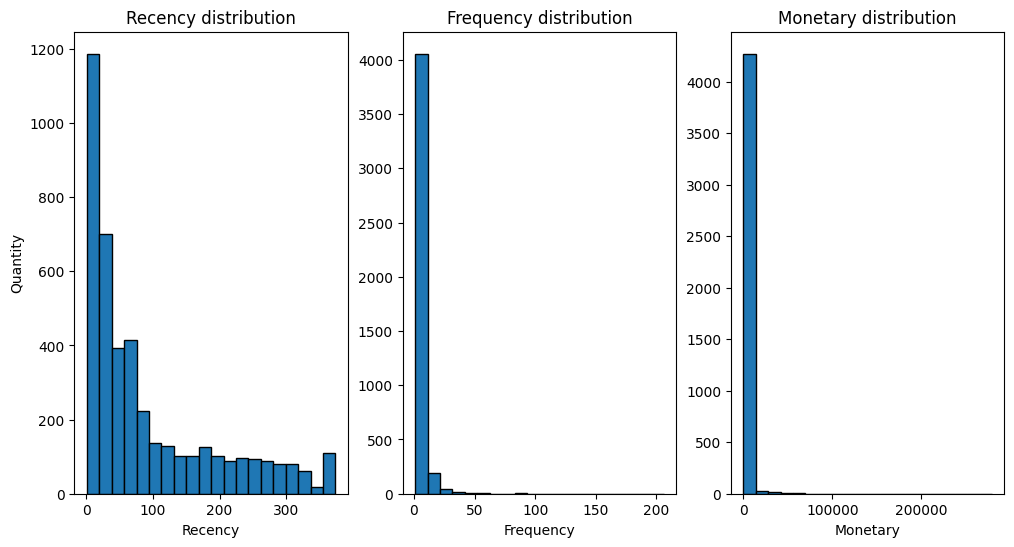

In [715]:
fig, ax = plt.subplots(1,3, figsize=(12,6))

ax[0].hist(rfm['Recency'], bins=20, edgecolor='black')
ax[0].set_title('Recency distribution')
ax[0].set_ylabel('Quantity')
ax[0].set_xlabel('Recency')

ax[1].hist(rfm['Frequency'], bins=20, edgecolor='black')
ax[1].set_title('Frequency distribution')
ax[1].set_xlabel('Frequency')

ax[2].hist(rfm['Monetary'], bins=20, edgecolor='black')
ax[2].set_title('Monetary distribution')
ax[2].set_xlabel('Monetary')

plt.show()

Através destes gráficos de distribuição podemos também notar os outliers, ficam muito evidentes em Frequency e Monetary visto que temos uma alta concentração em valores baixos e um efeito **cauda longa** nestes gráficos, pouquíssimos registros altos, fazendo com que a **escala do gráfico se expanda excessivamente**, isso atrapalha muito a visualização, Estes registros não necessariamente estão errados (pode ter um registro onde uma pessoa gastou muito dinheiro ou é um cliente de muita frequência) então usaremos o **winsorize (filtrando) e guardaremos em outro dataframe**.

o winsorize consiste em **limitar os valores extremos de uma variável a determinados percentis** (por exemplo, 1% e 99%), substituindo os valores muito altos ou muito baixos pelos limites definidos. Essa abordagem preserva todos os registros do dataset, ao mesmo tempo em que reduz a influência dos outliers nas análises estatísticas e na visualização dos dados.


### Verificando os percentis extremos :

In [716]:
rfm['Monetary'].describe(percentiles=[.01, .05, .5, .9, .95, .99]).round(1)

count      4334.0
mean       2016.0
std        8903.7
min           3.8
1%           52.2
5%          111.0
50%         662.6
90%        3560.1
95%        5735.2
99%       18715.3
max      279138.0
Name: Monetary, dtype: float64

O mínimo é 3.75 e apenas 1% dos dados estão abaixo de 52, ou seja, é um outlier claro.

O máximo é 279138 99% dos dados estão abaixo de 18715.3, o valor máximo é 14 vezes maior que o maior dos outros 99% dos dados, então é com certeza um outlier que acaba distorcendo a escala do gráfico.

In [717]:
rfm['Frequency'].describe(percentiles=[.01, .05, .5, .9, .95, .99]).round(1)


count    4334.0
mean        4.2
std         7.6
min         1.0
1%          1.0
5%          1.0
50%         2.0
90%         9.0
95%        13.0
99%        30.0
max       206.0
Name: Frequency, dtype: float64

O máximo é 206 e 99% dos dados estão abaixo de 30 dias, então estes dados acabam distorcendo a escala da distribuição de Frequency

### Verificando através do boxplot : 

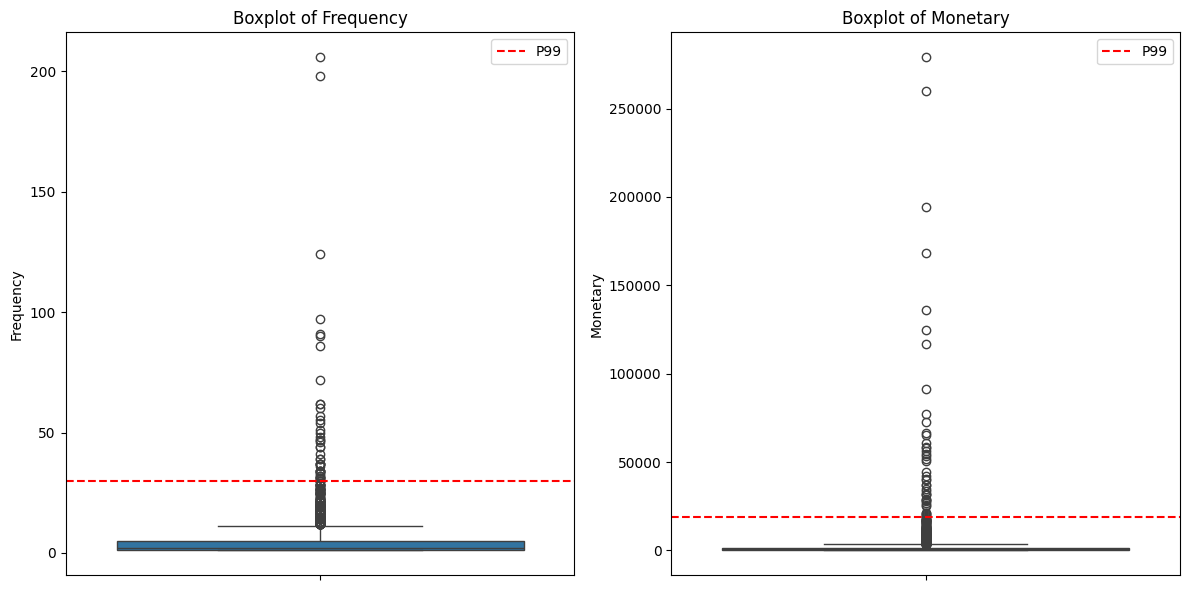

In [718]:
freq_p99 = rfm['Frequency'].quantile(0.99)
mon_p99 = rfm['Monetary'].quantile(0.99)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(y='Frequency', data=rfm, ax=axes[0])
axes[0].axhline(freq_p99, color='red', linestyle='--', label='P99')
axes[0].set_title('Boxplot of Frequency')
axes[0].legend()

sns.boxplot(y='Monetary', data=rfm, ax=axes[1])
axes[1].axhline(mon_p99, color='red', linestyle='--', label='P99')
axes[1].set_title('Boxplot of Monetary')
axes[1].legend()

plt.tight_layout()
plt.show()


FIca explícito que há valores extremos tanto em Frequency quanto em Monetary, a linha tracejada em vermelho representa o threshold (limiar) que separa os dados, abaixo ou bem nesta linha há 99% dos dados 

In [751]:
def winsorize(series, lower=0.01, upper=0.99):
    return series.clip(
        lower=series.quantile(lower),
        upper=series.quantile(upper)
    )

rfm_w = rfm.copy()

for col in ['Recency', 'Frequency', 'Monetary']:
    rfm_w[col] = winsorize(rfm[col])


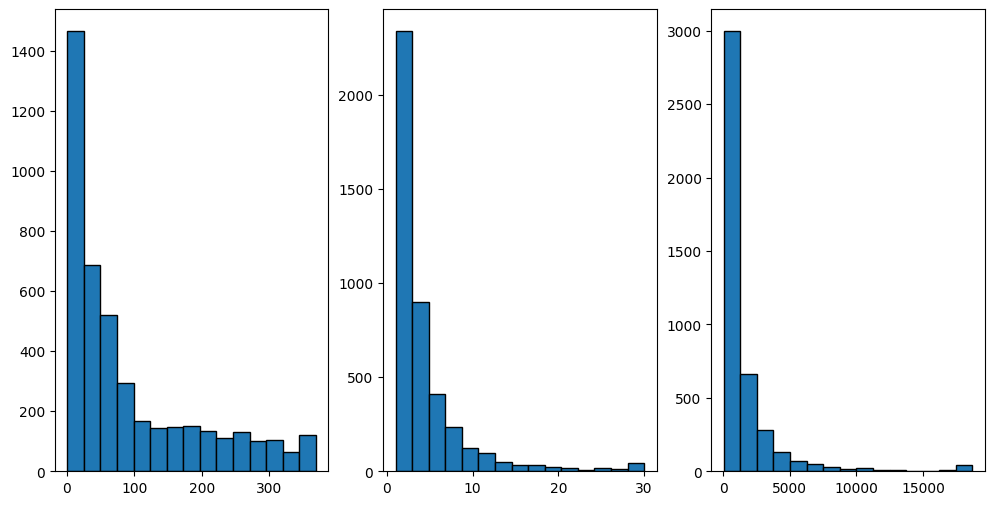

In [720]:
fig, ax = plt.subplots(1,3, figsize=(12,6))

ax[0].hist(rfm_w['Recency'], bins=15, edgecolor='black')
ax[1].hist(rfm_w['Frequency'], bins=15, edgecolor='black')
ax[2].hist(rfm_w['Monetary'], bins=15, edgecolor='black')

plt.show()

In [ ]:
top5_products = df['Description'].value_counts().head(5).index
top5_countries = df['Country'].value_counts().head(5).index
top5_products_rev_df = (
    df.groupby('Description', as_index=False)['Revenue']
      .sum()
      .sort_values('Revenue', ascending=False)
      .head(5)
)


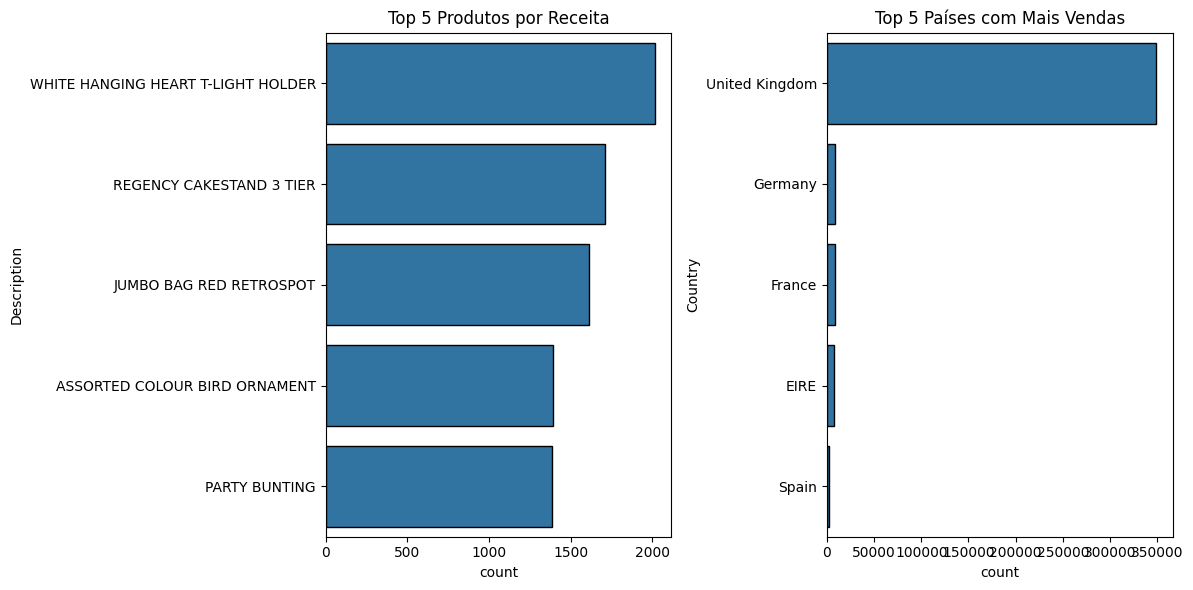

In [723]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(
    y='Description',
    data=df[df['Description'].isin(top5_products)],
    order=top5_products,
    edgecolor='black',
    ax=axes[0]
)
axes[0].set_title('Top 5 Produtos Mais Vendidos')

sns.countplot(
    y='Country',
    data=df[df['Country'].isin(top5_countries)],
    order=top5_countries,
    edgecolor='black',
    ax=axes[1]
)

axes[0].set_title('Top 5 Produtos por Receita')
axes[1].set_title('Top 5 Países com Mais Vendas')



plt.tight_layout()
plt.show()


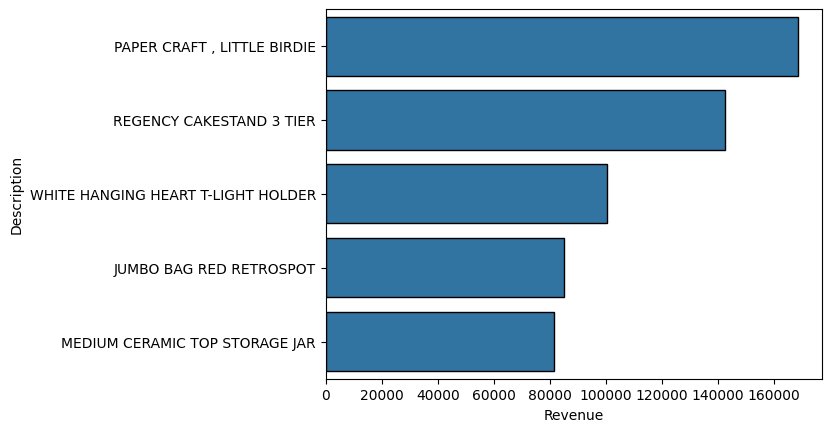

In [724]:
sns.barplot(
    y='Description',
    x='Revenue',
    data=top5_products_rev_df,
    edgecolor='black',
)

plt.show()

In [725]:
df_daily = (
    df.groupby(df['InvoiceDate'].dt.date)
      .agg({
          'Quantity': 'sum',
          'Revenue': 'sum'
      })
      .reset_index()
)

df_daily.rename(columns={'InvoiceDate': 'Date'}, inplace=True)


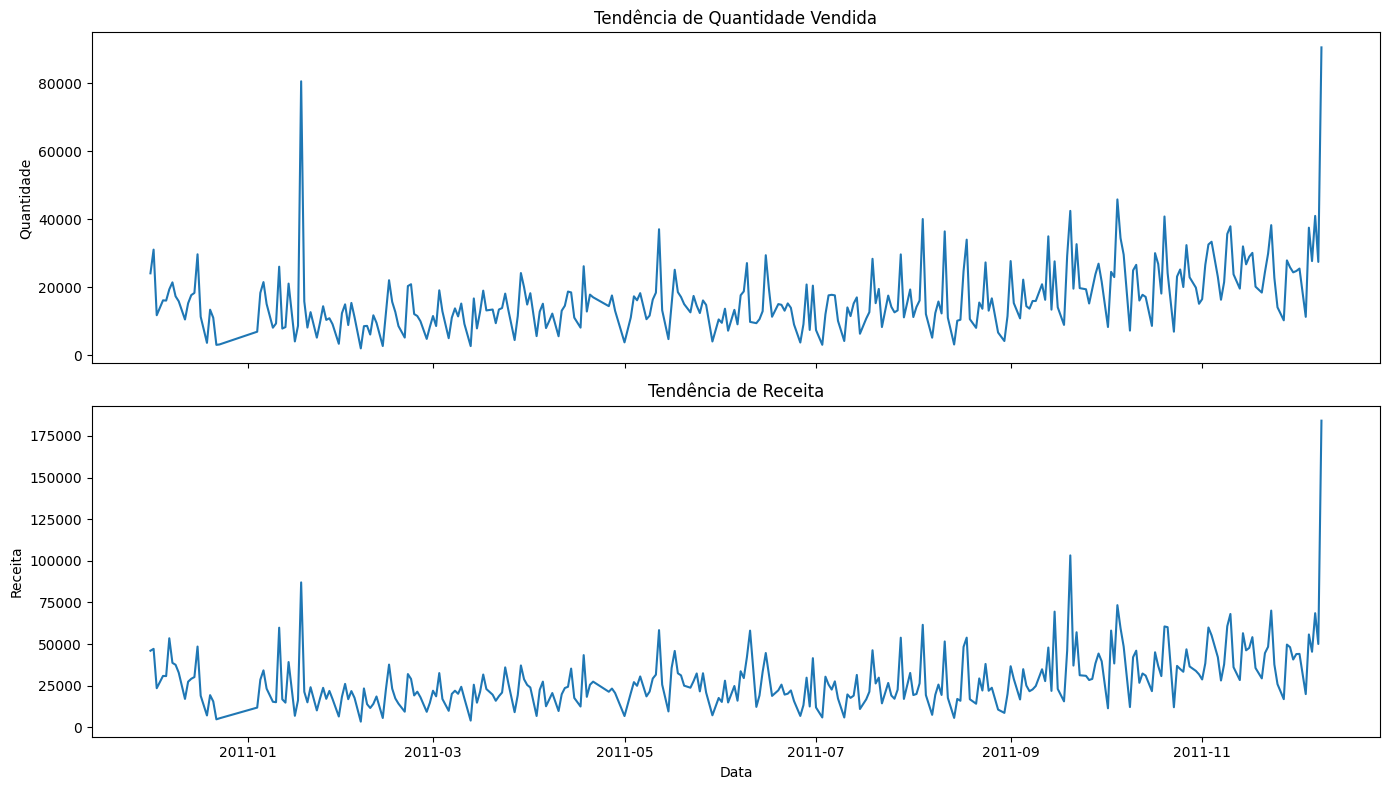

In [726]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

axes[0].plot(df_daily['Date'], df_daily['Quantity'])
axes[0].set_title('Tendência de Quantidade Vendida')
axes[0].set_ylabel('Quantidade')

axes[1].plot(df_daily['Date'], df_daily['Revenue'])
axes[1].set_title('Tendência de Receita')
axes[1].set_ylabel('Receita')
axes[1].set_xlabel('Data')

plt.tight_layout()
plt.show()


In [727]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.3


In [728]:
rfm.head(1)

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.6


In [729]:
scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(
    rfm[['Recency', 'Frequency', 'Monetary']]
)

rfm_scaled = pd.DataFrame(
    rfm_scaled,
    columns=['Recency', 'Frequency', 'Monetary'],
    index=rfm.index
)


In [730]:
pca = PCA()
pca.fit(rfm_scaled)

explained_variance = pca.explained_variance_ratio_

explained_variance


array([0.55323304, 0.30251578, 0.14425119])

In [731]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

rfm_pca = pd.DataFrame(
    rfm_pca,
    columns=['PC1', 'PC2'],
    index=rfm.index
)


In [732]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)


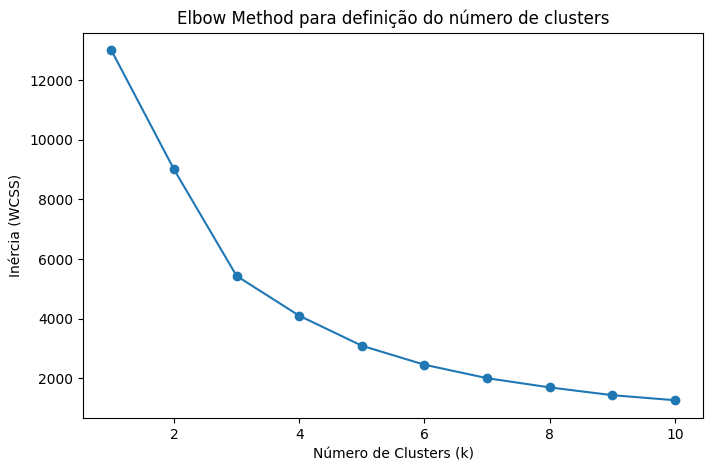

In [733]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (WCSS)')
plt.title('Elbow Method para definição do número de clusters')
plt.show()


In [734]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

In [735]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,cluster
0,12346.0,326,1,77183.60,1
1,12347.0,2,7,4310.00,0
2,12348.0,75,4,1437.24,0
3,12349.0,19,1,1457.55,0
4,12350.0,310,1,294.40,1


In [736]:
rfm.groupby('cluster')[['Recency', 'Frequency', 'Monetary']].mean()


,Recency,Frequency,Monetary
cluster,,,
0,40.990701,4.826100,1970.191262
1,246.287934,1.572212,623.486188
2,7.142857,79.500000,121378.338571


In [737]:
rfm.groupby('cluster')[['Recency', 'Frequency', 'Monetary']].median()


,Recency,Frequency,Monetary
cluster,,,
0,30.0,3.0,912.30
1,241.0,1.0,309.46
2,2.5,61.0,103811.23


In [738]:
rfm['cluster'].value_counts(normalize=True) * 100


cluster
0    74.434702
1    25.242270
2     0.323027
Name: proportion, dtype: float64

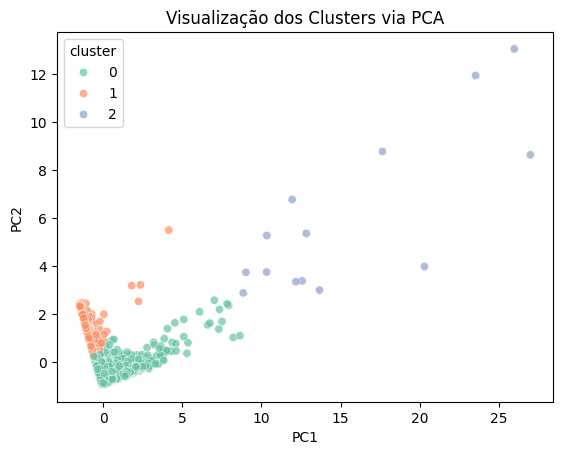

In [739]:
rfm_pca['cluster'] = rfm['cluster']

sns.scatterplot(
    data=rfm_pca,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette='Set2',
    alpha=0.7
)
plt.title('Visualização dos Clusters via PCA')
plt.show()



In [740]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=5)
rfm['cluster_db'] = dbscan.fit_predict(rfm_scaled)

In [741]:
rfm['cluster_db'].value_counts()


cluster_db
 0    4292
-1      42
Name: count, dtype: int64

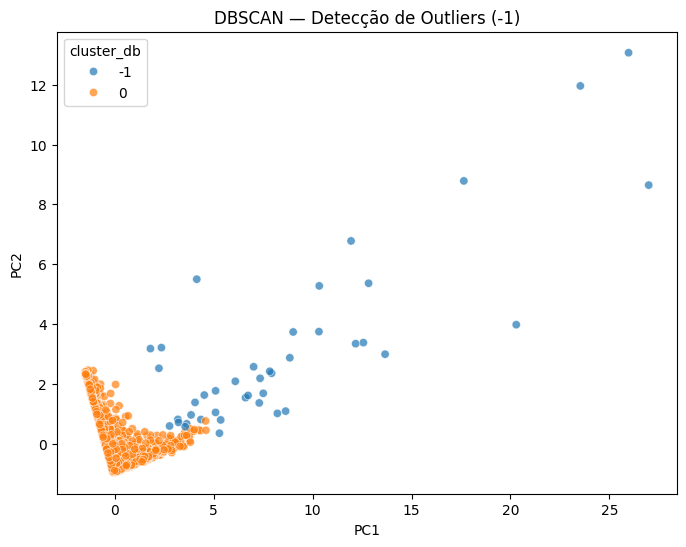

In [742]:
rfm_pca_db = rfm_pca.copy()
rfm_pca_db['cluster_db'] = rfm['cluster_db']

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm_pca_db,
    x='PC1',
    y='PC2',
    hue='cluster_db',
    palette='tab10',
    alpha=0.7
)
plt.title('DBSCAN — Detecção de Outliers (-1)')
plt.show()


In [743]:
rfm_clean = rfm[rfm['cluster_db'] != -1].copy()
rfm_scaled_clean = rfm_scaled[rfm['cluster_db'] != -1]


“Aplicamos DBSCAN como método complementar para identificação de clientes atípicos. Os pontos classificados como ruído (-1) foram removidos antes do treinamento final do KMeans, resultando em clusters mais estáveis e representativos do comportamento predominante da base.”

In [744]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0, n_init=20)
rfm_clean['cluster'] = kmeans.fit_predict(rfm_scaled_clean)


In [745]:
rfm_pca_clean = pca.fit_transform(rfm_scaled_clean)
rfm_pca_clean = pd.DataFrame(
    rfm_pca_clean,
    columns=['PC1', 'PC2'],
    index=rfm_clean.index
)

rfm_pca_clean['cluster'] = rfm_clean['cluster']


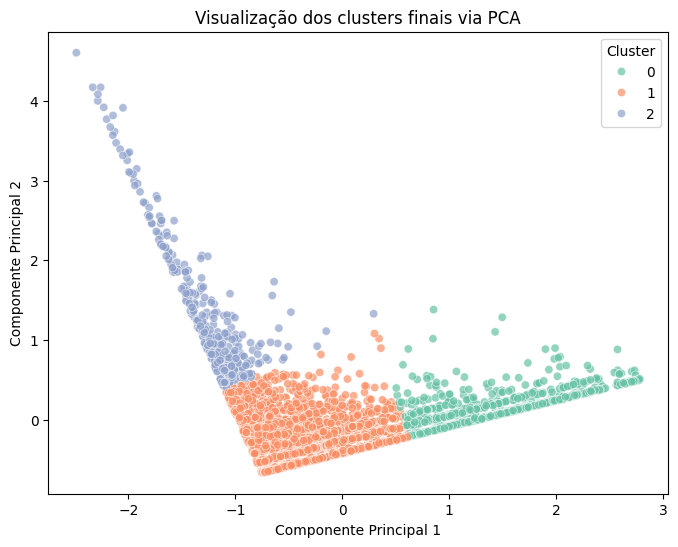

In [746]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=rfm_pca_clean,
    x='PC1',
    y='PC2',
    hue='cluster',
    palette='Set2',
    alpha=0.7
)

plt.title('Visualização dos clusters finais via PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()


In [747]:
rfm_cluster_summary = (
    rfm_clean
    .groupby('cluster')
    .agg(
        customers=('CustomerID', 'count'),
        recency_mean=('Recency', 'mean'),
        recency_median=('Recency', 'median'),
        frequency_mean=('Frequency', 'mean'),
        frequency_median=('Frequency', 'median'),
        monetary_mean=('Monetary', 'mean'),
        monetary_median=('Monetary', 'median')
    )
)

rfm_cluster_summary


,customers,recency_mean,recency_median,frequency_mean,frequency_median,monetary_mean,monetary_median
cluster,,,,,,,
0,1059,249.221907,244.0,1.542021,1.0,473.079679,307.90
1,2871,45.725531,36.0,3.167886,3.0,1151.652685,744.85
2,362,14.331492,9.0,15.538674,13.0,6096.903674,4805.42


In [748]:
rfm_clean['cluster'].value_counts(normalize=True) * 100


cluster
1    66.891892
0    24.673812
2     8.434296
Name: proportion, dtype: float64

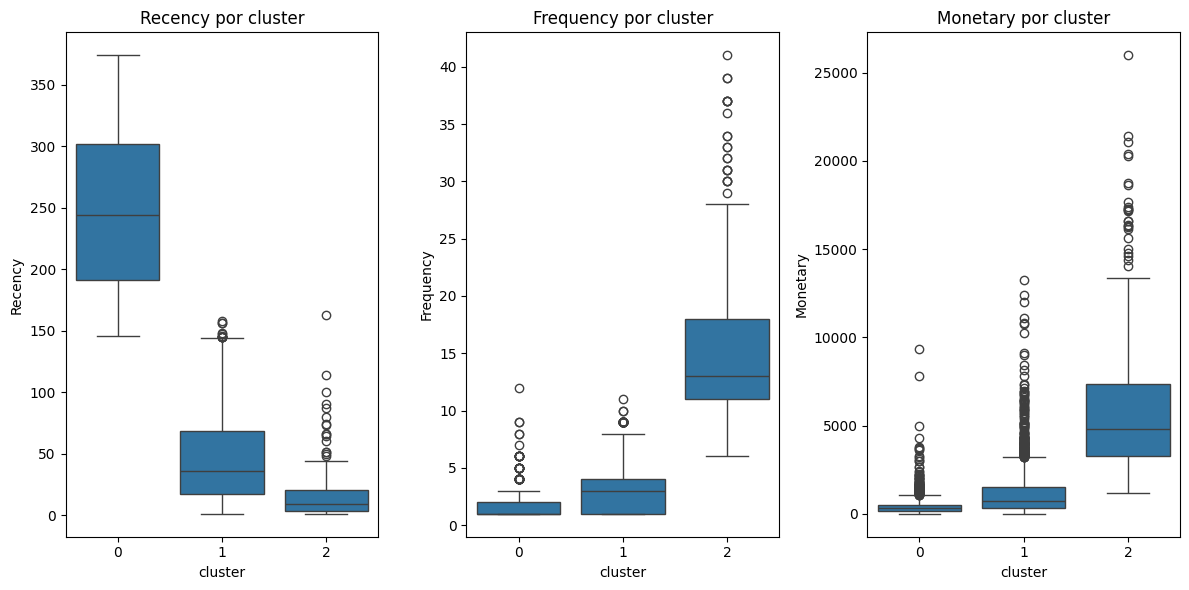

In [749]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

sns.boxplot(data=rfm_clean, x='cluster', y='Recency', ax=axes[0])
sns.boxplot(data=rfm_clean, x='cluster', y='Frequency', ax=axes[1])
sns.boxplot(data=rfm_clean, x='cluster', y='Monetary', ax=axes[2])

axes[0].set_title('Recency por cluster')
axes[1].set_title('Frequency por cluster')
axes[2].set_title('Monetary por cluster')

plt.tight_layout()
plt.show()


In [750]:
rfm_cluster_summary['R_rank'] = rfm_cluster_summary['recency_median'].rank(ascending=True)
rfm_cluster_summary['F_rank'] = rfm_cluster_summary['frequency_median'].rank(ascending=False)
rfm_cluster_summary['M_rank'] = rfm_cluster_summary['monetary_median'].rank(ascending=False)

rfm_cluster_summary.sort_values(
    by=['R_rank', 'F_rank', 'M_rank']
)


,customers,recency_mean,recency_median,frequency_mean,frequency_median,monetary_mean,monetary_median,R_rank,F_rank,M_rank
cluster,,,,,,,,,,
2,362,14.331492,9.0,15.538674,13.0,6096.903674,4805.42,1.0,1.0,1.0
1,2871,45.725531,36.0,3.167886,3.0,1151.652685,744.85,2.0,2.0,2.0
0,1059,249.221907,244.0,1.542021,1.0,473.079679,307.90,3.0,3.0,3.0


Analisar